In [156]:
#first lets see where the cifar 10 dataset is, hopefully in torchvision
import torch, torchvision
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision import transforms
from torchvision import models
from torchvision.datasets import CIFAR10
from torchvision.transforms import ToTensor
import torchmetrics

print(f"Torch version: {torch.__version__}, Torchvision version: {torchvision.__version__}")
 



Torch version: 2.5.1, Torchvision version: 0.20.1


In [157]:
#next some device agnostic code:
if torch.cuda.is_available():
    device = "cuda"
elif torch.backends.mps.is_available():
    device = "mps"
else:
    device = "cpu"
print(device)

mps


In [158]:
#lets get our paths in order using pathlib
from pathlib import Path
from datetime import datetime

MODEL_NAME = "CIFAR10"
EXPERIMENT_NAME = "EXP_1"

now = datetime.now()
TIMESTAMP = f"{now.month}-{now.day}-{str(now.year)[-2:]}-@-{now.strftime('%I_%M_%S%p')}"

BASE_DIR = Path(MODEL_NAME)

DATA_DIR = BASE_DIR / "data"
EXPERIMENT_DIR = BASE_DIR / EXPERIMENT_NAME

#OTHER DIRS
MODEL_DIR = EXPERIMENT_DIR / "models"
GRAPHS_DIR = EXPERIMENT_DIR / "graphs"
RESULTS_DIR = EXPERIMENT_DIR / "results"
LOSS_DIR = GRAPHS_DIR / "loss"
ACCURACY_DIR = GRAPHS_DIR / "accuracy"

#now to make the directories

for directory in [MODEL_DIR,GRAPHS_DIR,RESULTS_DIR,LOSS_DIR,ACCURACY_DIR,DATA_DIR]:
    directory.mkdir(parents=True,exist_ok=True)

MODEL_PATH = MODEL_DIR / f"{MODEL_NAME}-{EXPERIMENT_NAME}-{TIMESTAMP}"
RESULTS_PATH = RESULTS_DIR / f"{MODEL_NAME}-{EXPERIMENT_NAME}-{TIMESTAMP}"
LOSS_GRAPH_PATH = LOSS_DIR / f"{MODEL_NAME}-{EXPERIMENT_NAME}-{TIMESTAMP}"
ACC_GRAPH_PATH = ACCURACY_DIR / f"{MODEL_NAME}-{EXPERIMENT_NAME}-{TIMESTAMP}"


In [159]:
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(224, padding=4),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],  # ImageNet means
        std=[0.229, 0.224, 0.225]
    )
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

In [160]:
train_data = datasets.CIFAR10(
    root=DATA_DIR,
    train=True,
    transform=train_transform,
    download=True
)

test_data = datasets.CIFAR10(
    root=DATA_DIR,
    train=False,
    transform=test_transform,
    download=True
)

Files already downloaded and verified
Files already downloaded and verified


In [161]:
len(train_data) #returns 50000, or the size of the training set
len(test_data) #10000 size of testing data
type(train_data[0]) #this is a tuple
len(train_data[0]) #size two tuple
train_data[0][0] #the tensor object, torch.tensor
train_data[0][1] #this is a class, namely the class 6
train_data[0][0].shape #shape is 3,32,32 or im guessing RGB,then rows(height) then cols(width)

image, label = train_data[0]
image.shape #3,32,32


torch.Size([3, 224, 224])

In [162]:
len(train_data.data), len(train_data.targets)

#as for the names of the classes:
classes = train_data.classes
len(classes) #10 classes total
print(classes)

['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.3935575].


Image shape: torch.Size([3, 224, 224])


Text(0.5, 1.0, 'Image 0, Class: frog')

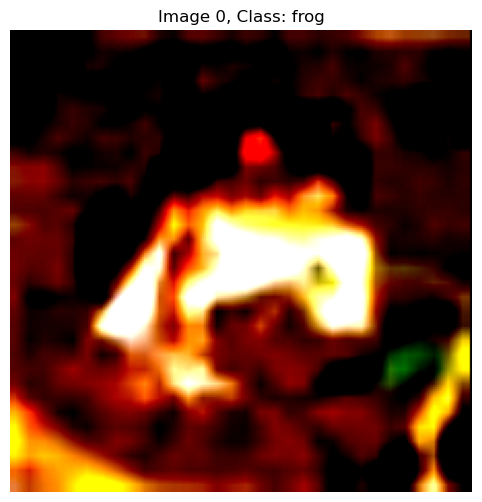

In [163]:
#plot some of the images using matplotlib imshow, which takes 2d array of values and graphs it
#WHEN PLOTING, MUST BE H, W, C
import matplotlib.pyplot as plt
image,label = train_data[0]
print(f"Image shape: {image.shape}")
plt.figure(figsize=(10,6))
plt.imshow(image.permute(1,2,0)) #remember to permute so height,width,channels
plt.axis(False)
plt.title(f"Image {0}, Class: {classes[label]}")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..1.8158263].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.8956583..2.5528543].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.5702832].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.5528543].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.1804092].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
C

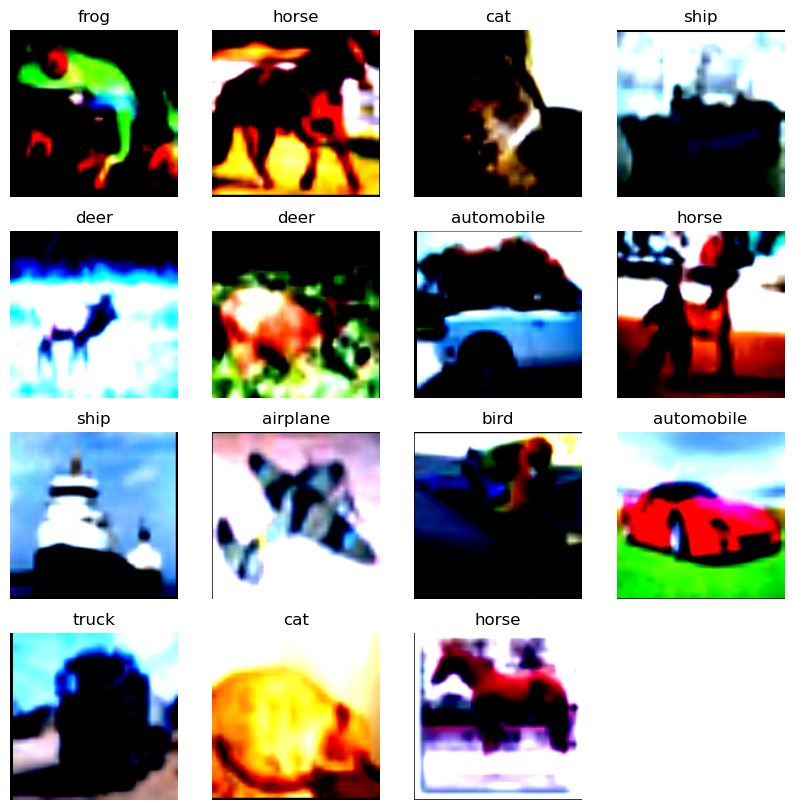

In [164]:
#code to plot a 2d array of images:

rows,cols = 4,4
torch.manual_seed(42)
plt.figure(figsize=(10,10))

#will be from 0 inclusive to rows * cols exclusive
for i in range (1,rows*cols,1):
    plt.subplot(rows,cols,i)
    image,label = train_data[torch.randint(low=0,high=len(train_data),size=[1]).item()]#returns the actual tuple
    plt.imshow(image.permute(1,2,0))
    plt.title(classes[label])
    plt.axis(False)



In [165]:
#getting the dataloaders ready:

BATCH_SIZE = 32

train_dataloader = DataLoader(train_data, batch_size=64, shuffle=True, num_workers=2, pin_memory=True)
test_dataloader  = DataLoader(test_data,  batch_size=64, shuffle=False, num_workers=2, pin_memory=True)

len(train_dataloader), len(test_dataloader)

(782, 157)

In [166]:
#now lets make the model:

model = torchvision.models.alexnet(weights=None)
model.classifier[6] = nn.Linear(4096, len(classes))
model = model.to(device)


In [167]:
#now the loss function and optimizer
from torchmetrics.classification import Accuracy

loss_fn = torch.nn.CrossEntropyLoss() #logit based
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)



In [168]:
#homemade accuracy function:
def accuracy_function(predicted_batch_labels: torch.Tensor,actual_batch_labels: torch.Tensor):
    number_correct = torch.eq(predicted_batch_labels,actual_batch_labels).sum().item()
    return (number_correct / len(predicted_batch_labels)) * 100

In [169]:
def evaluate_model(
    model: torch.nn.Module,
    dataloader: torch.utils.data.DataLoader,
    loss_funct: torch.nn.Module,
    accuracy_funct,
    device: torch.device,
):
    model.eval()
    epoch_loss = 0.0
    epoch_acc  = 0.0

    with torch.inference_mode():
        for batch_evaluation_features, batch_evaluation_labels in dataloader:
            # move data to device
            batch_evaluation_features = batch_evaluation_features.to(device)
            batch_evaluation_labels   = batch_evaluation_labels.to(device)

            # forward pass
            y_eval_logit_preds = model(batch_evaluation_features)  # (B, num_classes)
            y_eval_preds = torch.softmax(y_eval_logit_preds, dim=1).argmax(dim=1)  # (B,)

            # loss
            loss = loss_funct(y_eval_logit_preds, batch_evaluation_labels)
            epoch_loss += loss.item()

            # accuracy
            acc = accuracy_funct(y_eval_preds, batch_evaluation_labels)
            # handle if accuracy_funct returns a tensor or float
            if isinstance(acc, torch.Tensor):
                acc = acc.item()
            epoch_acc += acc

    epoch_loss /= len(dataloader)
    epoch_acc  /= len(dataloader)

    results_dict = {
        "model_name": f"{model.__class__.__name__}",
        "model_loss": epoch_loss,
        "model_accuracy": epoch_acc,
    }
    return results_dict


In [170]:
import torch

def train_step(model, dataloader, loss_funct, optimizer, accuracy_obj, device):
    model.train()
    accuracy_obj.reset()

    epoch_loss = 0.0

    for features, labels in dataloader:
        features = features.to(device)
        labels   = labels.to(device)

        logits = model(features)                      # (B, num_classes)
        preds  = torch.softmax(logits, dim=1).argmax(dim=1)

        loss = loss_funct(logits, labels)

        epoch_loss += loss.item()
        accuracy_obj.update(preds, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    epoch_loss /= len(dataloader)
    accuracy = accuracy_obj.compute().item()

    return {"Training Loss": epoch_loss, "Training Accuracy": accuracy}


In [171]:
def test_step(model, dataloader, loss_funct, accuracy_obj, device):
    model.eval()
    accuracy_obj.reset()

    epoch_loss = 0.0

    with torch.inference_mode():
        for features, labels in dataloader:
            features = features.to(device)
            labels   = labels.to(device)

            logits = model(features)
            preds  = torch.softmax(logits, dim=1).argmax(dim=1)

            loss = loss_funct(logits, labels)

            epoch_loss += loss.item()
            accuracy_obj.update(preds, labels)

    epoch_loss /= len(dataloader)
    accuracy = accuracy_obj.compute().item()

    return {"Testing Loss": epoch_loss, "Testing Accuracy": accuracy}

In [172]:
#Now, lets impliment a save checkpoint function to save the state of where we were. Best way is to use the torch.save to save a dict that contains the 
#epoch, model's state dict, and optimizer's state dict

def save_checkpoint(epoch: int, model: torch.nn.Module, optimizer: torch.optim.Optimizer, checkpoint_dir: Path):
    

    checkpoint_name = f"CHECKPOINT_{MODEL_NAME}_{EXPERIMENT_NAME}_{TIMESTAMP}_FOR_EPOCH_{epoch}"
    checkpoint_path = checkpoint_dir / checkpoint_name

    checkpoint = {
        "Epoch": epoch,
        "model_state_dict": model.state_dict(),
        "optimizer_state_dict": optimizer.state_dict()
    }
    torch.save(obj=checkpoint,f=checkpoint_path)
    print(f"Successfully Saved Checkpoint at Epoch {epoch}")


In [173]:
from tqdm.auto import tqdm
from timeit import default_timer as timer
import csv
from torchmetrics.classification import Accuracy

torch.manual_seed(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

EPOCHS = 10
num_classes = len(classes)


with open(file=RESULTS_PATH, mode="w", newline="") as file:
    writer = csv.writer(file)
    writer.writerow(["Epoch", "Training Loss", "Testing Loss",
                     "Training Accuracy", "Testing Accuracy"])

    # define metrics once, reset every epoch
    train_acc_metric = Accuracy(task="multiclass", num_classes=num_classes).to(device)
    test_acc_metric  = Accuracy(task="multiclass", num_classes=num_classes).to(device)

    # epoch loop with tqdm
    for epoch in tqdm(range(EPOCHS)):
        print(f"\nEpoch {epoch+1}/{EPOCHS}")
        print("-------")

        # reset metrics each epoch
        train_acc_metric.reset()
        test_acc_metric.reset()

        # one epoch of training
        train_results = train_step(
            model=model,
            dataloader=train_dataloader,
            loss_funct=loss_fn,
            optimizer=optimizer,
            accuracy_obj=train_acc_metric,
            device=device,
        )

        # one epoch of testing
        test_results = test_step(
            model=model,
            dataloader=test_dataloader,
            loss_funct=loss_fn,
            accuracy_obj=test_acc_metric,
            device=device,
        )

        # values for CSV/logging
        train_loss = train_results["Training Loss"]
        test_loss  = test_results["Testing Loss"]
        train_acc  = train_results["Training Accuracy"]
        test_acc   = test_results["Testing Accuracy"]

        # write to CSV
        writer.writerow([epoch, train_loss, test_loss, train_acc, test_acc])

        # nice printout
        print(
            f"Train Loss: {train_loss:.4f} | "
            f"Train Acc: {train_acc:.4f} | "
            f"Test Loss: {test_loss:.4f} | "
            f"Test Acc: {test_acc:.4f}"
        )



  0%|          | 0/10 [00:00<?, ?it/s]


Epoch 1/10
-------


KeyboardInterrupt: 

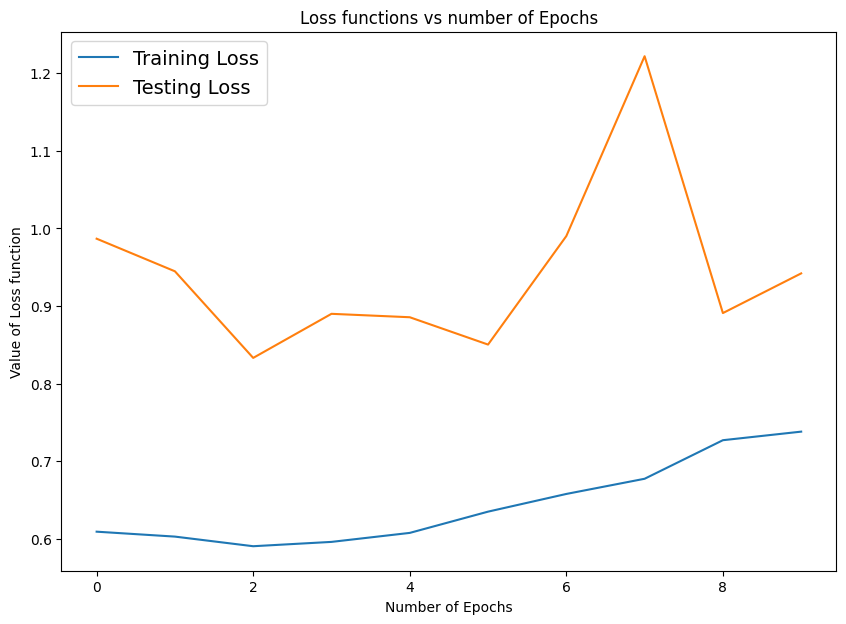

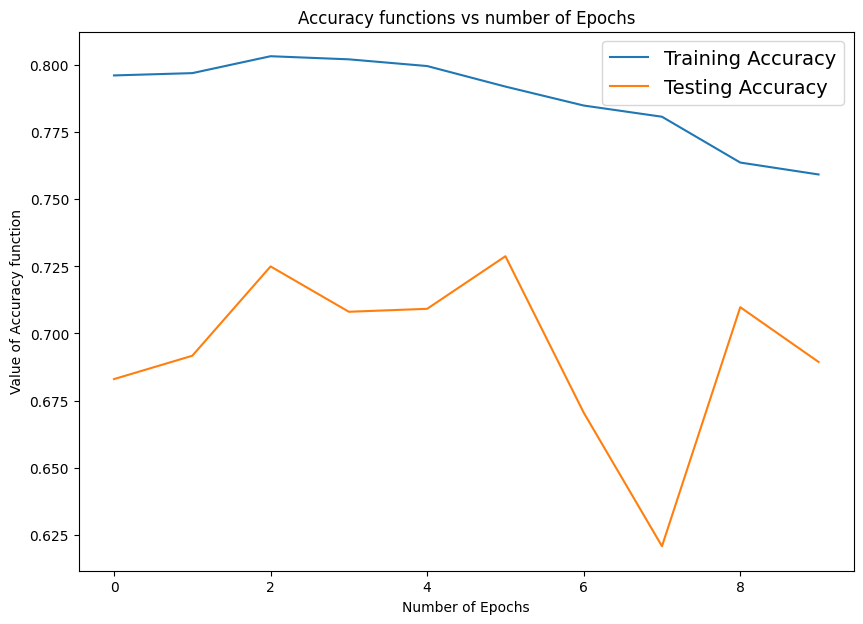

In [ ]:
data = pd.read_csv(filepath_or_buffer=RESULTS_PATH)

plt.figure(figsize=(10,7))
plt.plot(data["Epoch"],data["Training Loss"],label="Training Loss")
plt.plot(data["Epoch"],data["Testing Loss"],label="Testing Loss")
plt.xlabel("Number of Epochs")
plt.ylabel("Value of Loss function")
plt.title("Loss functions vs number of Epochs")
plt.legend(prop={"size":14})
plt.savefig(LOSS_GRAPH_PATH)
plt.show()
plt.close()

plt.figure(figsize=(10,7))
plt.plot(data["Epoch"],data["Training Accuracy"],label="Training Accuracy")
plt.plot(data["Epoch"],data["Testing Accuracy"],label="Testing Accuracy")
plt.xlabel("Number of Epochs")
plt.ylabel("Value of Accuracy function")
plt.title("Accuracy functions vs number of Epochs")
plt.legend(prop={"size":14})
plt.savefig(ACC_GRAPH_PATH)
plt.show()
plt.close()